## Colab Notebook created for ARAP module at UPC ETSETB.

Authors: Juan José Nieto, Margarita Cabrera-Bean, Josep Vidal

# WINDY GRID WORLD
[Open to access description of tasks](https://drive.google.com/file/d/1wVWxRwIfRSfhdicwuWKSorav-BmC7Thh/view?usp=sharing)

1. Complete the code for each algorithm (Sarsa, Q-Learning, Expected Sarsa and Double Q-Learning).
2. Modify the environment creatively following the description of tasks document


In [1]:
import numpy as np
import seaborn as sns

from random import random, randint
import matplotlib.pyplot as plt
algs = ['SARSA', 'Q-LEARNING', 'EXPECTED SARSA', 'DOUBLE Q-LEARNING']

In [2]:
class GridWorld():
    def __init__(self):
        self.N_ROWS = 10
        self.N_COLUMNS = 10
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        # Define parameters
        self.GAMMA = 1
        self.ALPHA = 0.5
        self.EPSILON = 0.1
        self.N_EPISODES = 2000

        # left/down/right/up action
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]

        self.N_ACTIONS = len(self.ACTIONS)
        
        # Define inital and final state
        self.INI_STATE = 6
        self.FIN_STATE = 76

        # Define wind for each row and column
        self.WIND_V = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
        self.WIND_H = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        # Define action-value function
        self.Q_FUN = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define second action-value function for double q-learning
        self.Q_FUN2 = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define state-value function only for plotting purposes    
        self.V_FUN = np.zeros(self.N_STATES)


    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1]*self.N_COLUMNS + state[0]


    '''
    Computes next state and reward

    Params:
        - int: state in {0,..., N_STATES-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: reward
    '''
    def next_position(self, state, action):

        (x,y) = self.get_XY(state)
        # x is the row number and y is the column number
        (ax, ay) = self.ACTIONS[action]

        row = max(0, x + ax + self.WIND_V[y])
        row = min(self.N_ROWS-1, row)
        col = max(0, y + ay + self.WIND_H[x])
        col = min(self.N_COLUMNS-1, col)
        
        next_state = (row, col)

        next_state = self.get_state(next_state)

        if next_state == self.FIN_STATE:
            return next_state, 0
        return next_state, -1

    '''
    Performs greedy policy. With prob epsilon pick action
    belonging to maximum action-value. With prob 1-epsilon
    pick a random action.

    Params:
        - int: state in {0,..., N_STATES-1}
        - bool: double, indicates whether we are using double q-learning or not
    Returns:
        - int: action in {0,..., N_ACTIONS-1}
    '''
    def greedy_policy(self, state, double=False):

        action = np.argmax(self.Q_FUN[state])
        if double:
            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state])

        if random() < self.EPSILON:
            action = randint(0, self.N_ACTIONS - 1)
        
        return action

    '''
    Compute state-value function

    Returns:
        - list: V_FUN
    '''
    def compute_v_fun(self):
        for i, action_values in enumerate(self.Q_FUN):
            self.V_FUN[i] = np.max(self.Q_FUN[i] + self.Q_FUN2[i])  # QFUN2[i] will be != 0 only in Double Q-Learning
        return self.V_FUN

    '''
    Compute actions taken in each state.

    Params:
        - boolean: double, indicates whether we are using double q-learning or not
    Returns:
        - list: actions, one for each state
    '''
    def compute_actions(self, double=False):
        actions = []
        for s in range(self.N_STATES):
            if double:
                actions.append(np.argmax(self.Q_FUN[s] + self.Q_FUN2[s]))
            else:
                actions.append(np.argmax(self.Q_FUN[s]))

        return actions

    '''
    The following functions are the different algorithms we will try.
    Basically we do two things:
        1. Compute next_state and next_action
        2. Update action-values (Q_FUN)

    Params:
        - int: state in {0,..., N_STATES-1}
        - int: action in {0,..., N_ACTIONS-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: next_action in {0,..., N_ACTIONS-1}
    '''
    def sarsa(self, state, action):
        
        # sarsa uses greedy policy for next action too
        
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state,next_action] - self.Q_FUN[state,action])
        
        return next_state, next_action
    

    def q_learning(self, state, action):

        # q-learning always pick next_action with maximum action-value (q-value)
        
        action = self.greedy_policy(state)
        next_state, reward = self.next_position(state, action)
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*np.max(self.Q_FUN[next_state]) - self.Q_FUN[state,action])
        
        return next_state, action


    def expected_sarsa(self, state, action):
        
        # expected sarsa is like q-learning but weighting with epsilon and also taking into account
        # the rest of action-values of that state

        next_state, reward = self.next_position(state, action)
        next_action = np.argmax(self.Q_FUN[next_state])
        
        policy = self.EPSILON/self.N_ACTIONS * np.ones(self.N_ACTIONS)
        policy[next_action] = 1 - self.EPSILON - self.EPSILON/self.N_ACTIONS
        
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*np.dot(policy, self.Q_FUN[next_state]) - self.Q_FUN[state,action])
        
        return next_state, next_action
    
    
    def double_q_learning(self, state, action):
        # Choose action taking into account both Q_FUNs

        # With 50% we will update Q_FUN or Q_FUN2. In either case, the actual q-value taken when computing the td_target
        # is given by the other Q_FUN, but we use the function we are updating to choose the next_action.
        
        action = self.greedy_policy(state, double=True)
        next_state, reward = self.next_position(state, action)
        
        if random() < 0.5:
            next_action = np.argmax(self.Q_FUN[next_state])
            self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN2[next_state, next_action] - self.Q_FUN[state,action])
        else:
            next_action = np.argmax(self.Q_FUN2[next_state])
            self.Q_FUN2[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state, next_action] - self.Q_FUN2[state,action])
        
        return next_state, action
    

    def deterministic_policy(self):
        max_steps = 50
        state = self.INI_STATE
        trajectory = np.zeros((self.N_ROWS, self.N_COLUMNS))
        steps = 0
        while not state == self.FIN_STATE and steps < max_steps:
            

            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state]) # QFUN2[i] will be != 0 only in Double Q-Learning
            next_state, reward = self.next_position(state, action)
            state = next_state
            steps += 1

            s = self.get_XY(state)
            trajectory[s[0], s[1]] = 1

        trajectory[s[0], s[1]] = 0
        if steps == max_steps:
            steps = 'inf'
        return trajectory, steps


### PLOT FUNCTIONS

In [3]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title']) 
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel']) 
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])

def general_plot(vf_matrix, counts, first_policy, optimal_policy, determ_policy, steps, grid):
    fig, ax = plt.subplots(5, len(vf_matrix), figsize=(20, 20))
    fig.tight_layout(pad=2.5)

    X = np.arange(0, 10, 1)
    Y = np.arange(0, 10, 1)

    s = 0.05
    actions = grid.ACTIONS
    
    r,t = grid.get_XY(grid.INI_STATE)
    w,e = grid.get_XY(grid.FIN_STATE)

    ini_pad_y = (grid.N_ROWS - r)*2-1
    g_pad_y = (grid.N_ROWS - w)*2-1

    ini_pad_x = t*2+1
    g_pad_x = e*2+1
    
    ini_pad_x = s*ini_pad_x-s/2
    ini_pad_y = s*ini_pad_y-s/2

    g_pad_x = s*g_pad_x-s/2
    g_pad_y = s*g_pad_y-s/2

    for i, data in enumerate([vf_matrix, counts, first_policy, optimal_policy, determ_policy]):
        for j, d in enumerate(data):
            if i==0:
                sns.heatmap(d, cmap='coolwarm', ax=ax[i, j])
                conf = {'title': '{} VALUE FUNCTION'.format(algs[j])}
                insert_labels(conf, ax[i, j])
            elif i==1:
                conf= {
                    'title': 'Number of steps in each episode',
                    'xlabel': 'Episode #',
                    'ylabel': 'number of steps'
                }
                ax[i,j].plot(d)
                insert_labels(conf, ax[i, j])
            elif i==2 or i==3:
                U = np.array([[actions[y][0] for y in x] for x in d])
                V = np.array([[actions[y][1] for y in x] for x in d])

                q = ax[i,j].quiver(X, Y, V, U*-1)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': '{} Policy'.format('First' if i==2 else 'Final')}
                insert_labels(conf, ax[i,j])
                
            elif i==4:
                U = np.array([[actions[y][0] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])
                V = np.array([[actions[y][1] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])

                q = ax[i,j].quiver(X, Y, V, U*-1, scale=5.3, scale_units='inches')
                
                ax[i,j].text(ini_pad_x, ini_pad_y, 'INI', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].text(g_pad_x, g_pad_y, 'G', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': 'Deterministic Policy. # Steps: {}'.format(steps[j])}
                insert_labels(conf, ax[i,j])






# ALGORITHMS:
1 -> SARSA

2 -> Q-LEARNING

3 -> EXPECTED SARSA

4 -> DOUBLE Q-LEARNING

# STANDARD GRID WORLD

In [4]:

total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []

for ALGORITHM in range(1,5):
    grid = GridWorld()
    counts = []
    for i in range(grid.N_EPISODES):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        n_count = 0
        
        while not state == grid.FIN_STATE:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action)

            action = next_action
            state = next_state

            n_count += 1
        if i==0:
            first_policy = grid.compute_actions()
        counts.append(n_count)
    
    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)


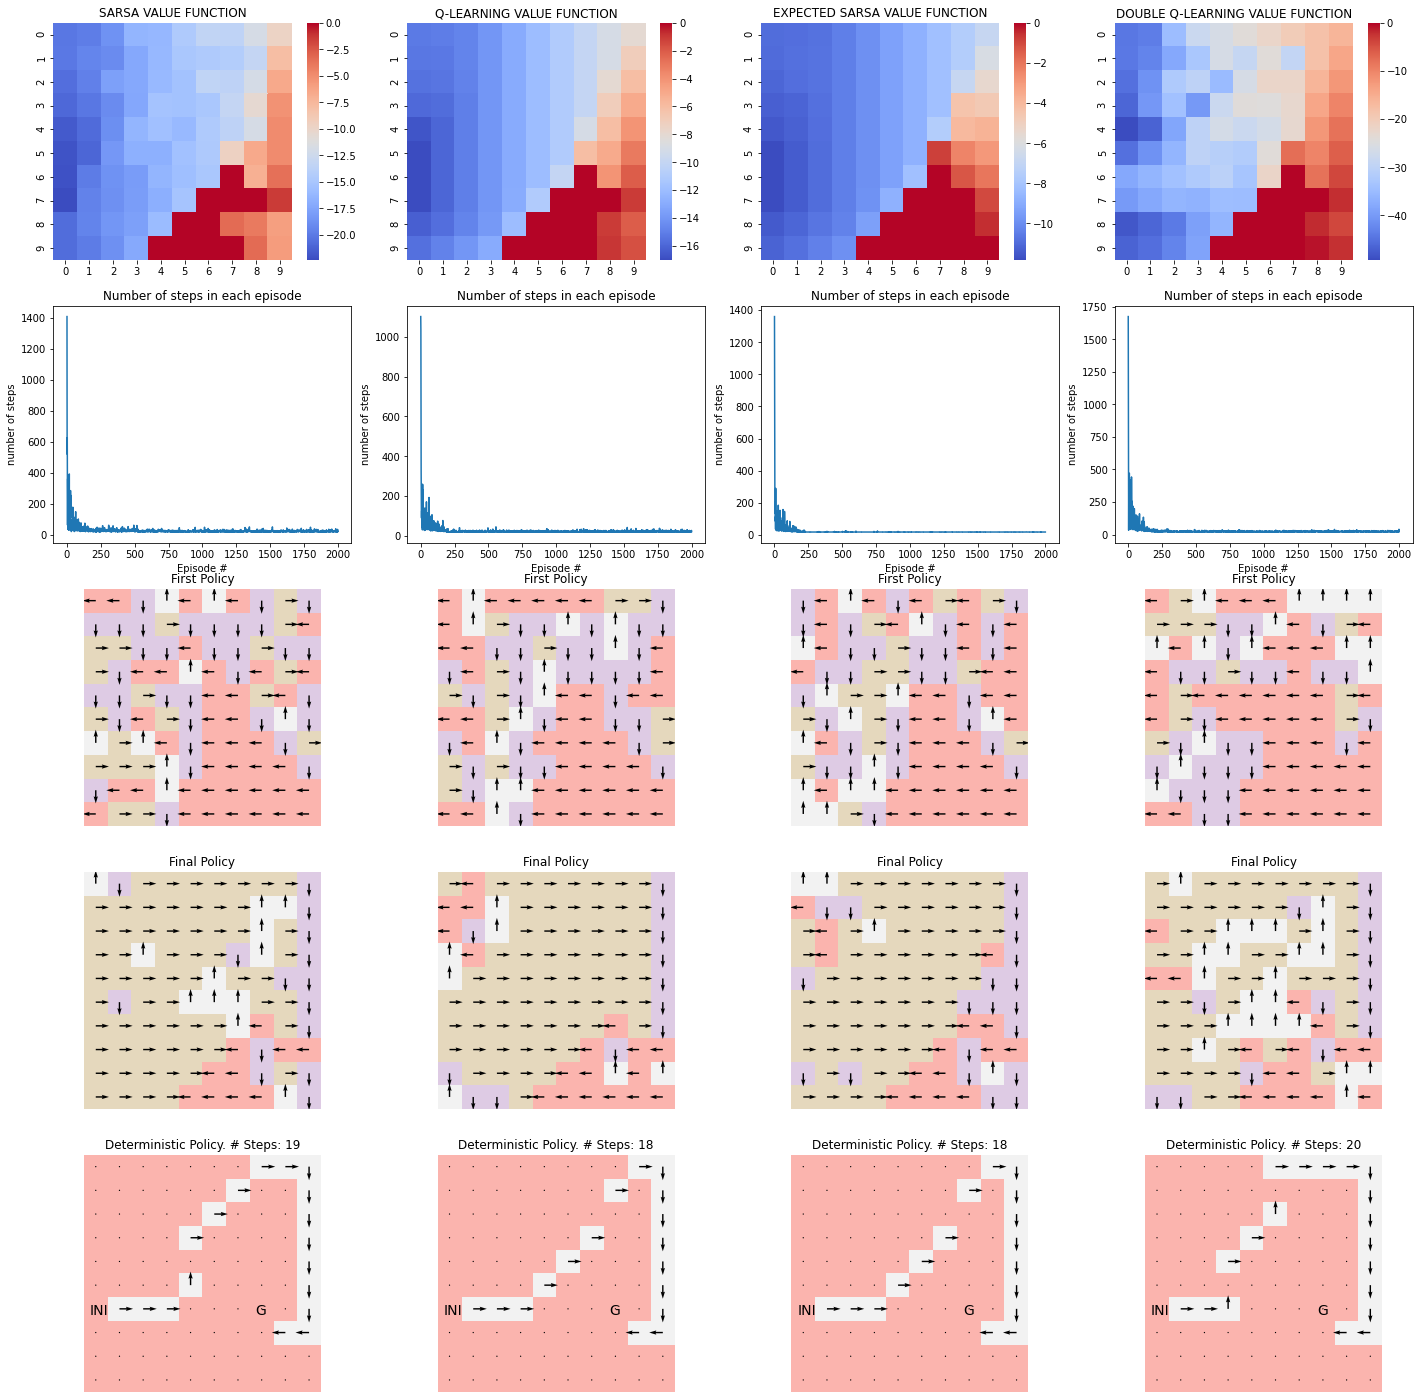

In [5]:
general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid)

The four algorithms take a similar number of steps to obtain the optimal policy but with some nuances on the way. For instance, in SARSA the number of steps it is very high throughout each episode (and specially at the very first ones). In the second plot, we see that Q-learning's number of steps is similar but with a small decrease of steps along the way. This behaviour is clearly seen in Expected SARSA, which eliminates the variance associated to the random selection of $A'$ on a $Q$ function possibly poorly estimated. The plot also shows a small number of steps in almost each new episode. And Double Q Learning performs well and generates a different deterministic policy than the others.

# Second Part

In this second part, we play a bit by adding some different features to the game. In this test we:
- Add diagonal moves (actions)
- Add negative horizontal wind
- Change the initial and final states position
- Select a group of 2x2 forbidden cells that the agent cannot access them

For doing so, we change some definitions of the class and modify the `next_position()` function.

In [9]:
class GridWorld():
    def __init__(self):
        self.N_ROWS = 10
        self.N_COLUMNS = 10
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        # Define parameters
        self.GAMMA = 1
        self.ALPHA = 0.5
        self.EPSILON = 0.1
        self.N_EPISODES = 2000

        # left/down/right/up action
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0), (1, 1), (1, -1), (-1, -1), (-1, 1)]

        self.N_ACTIONS = len(self.ACTIONS)
        
        # Define inital and final state
        self.INI_STATE = 18
        self.FIN_STATE = 81

        # Define wind for each row and column
        self.WIND_V = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
        self.WIND_H = [-1, -1, -2, -1, -1, 0, 0, 0, 0, 0]
        
        # Define forbidden cells
        self.BLOCK_CELLS = [56, 57, 66, 67]

        # Define action-value function
        self.Q_FUN = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define second action-value function for double q-learning
        self.Q_FUN2 = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define state-value function only for plotting purposes    
        self.V_FUN = np.zeros(self.N_STATES)


    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1]*self.N_COLUMNS + state[0]


    '''
    Computes next state and reward

    Params:
        - int: state in {0,..., N_STATES-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: reward
    '''
    def next_position(self, state, action):

        (x,y) = self.get_XY(state)
        # x is the row number and y is the column number
        (ax, ay) = self.ACTIONS[action]
        
        row = max(0, x + ax + self.WIND_V[y])
        row = min(self.N_ROWS-1, row)
        
        col = max(0, y + ay + self.WIND_H[x])
        col = min(self.N_COLUMNS-1, col)
        
        next_state = (row, col)

        next_state = self.get_state(next_state)
        next_state = next_state if next_state not in self.BLOCK_CELLS else state

        if next_state == self.FIN_STATE:
            return next_state, 0
        return next_state, -1

    '''
    Performs greedy policy. With prob epsilon pick action
    belonging to maximum action-value. With prob 1-epsilon
    pick a random action.

    Params:
        - int: state in {0,..., N_STATES-1}
        - bool: double, indicates whether we are using double q-learning or not
    Returns:
        - int: action in {0,..., N_ACTIONS-1}
    '''
    def greedy_policy(self, state, double=False):

        action = np.argmax(self.Q_FUN[state])
        if double:
            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state])

        if random() < self.EPSILON:
            action = randint(0, self.N_ACTIONS - 1)
        
        return action

    '''
    Compute state-value function

    Returns:
        - list: V_FUN
    '''
    def compute_v_fun(self):
        for i, action_values in enumerate(self.Q_FUN):
            self.V_FUN[i] = np.max(self.Q_FUN[i] + self.Q_FUN2[i])  # QFUN2[i] will be != 0 only in Double Q-Learning
        return self.V_FUN

    '''
    Compute actions taken in each state.

    Params:
        - boolean: double, indicates whether we are using double q-learning or not
    Returns:
        - list: actions, one for each state
    '''
    def compute_actions(self, double=False):
        actions = []
        for s in range(self.N_STATES):
            if double:
                actions.append(np.argmax(self.Q_FUN[s] + self.Q_FUN2[s]))
            else:
                actions.append(np.argmax(self.Q_FUN[s]))

        return actions

    '''
    The following functions are the different algorithms we will try.
    Basically we do two things:
        1. Compute next_state and next_action
        2. Update action-values (Q_FUN)

    Params:
        - int: state in {0,..., N_STATES-1}
        - int: action in {0,..., N_ACTIONS-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: next_action in {0,..., N_ACTIONS-1}
    '''
    def sarsa(self, state, action):
        
        # sarsa uses greedy policy for next action too
        
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state,next_action] - self.Q_FUN[state,action])
        
        return next_state, next_action
    

    def q_learning(self, state, action):

        # q-learning always pick next_action with maximum action-value (q-value)
        
        action = self.greedy_policy(state)
        next_state, reward = self.next_position(state, action)
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*np.max(self.Q_FUN[next_state]) - self.Q_FUN[state,action])
        
        return next_state, action


    def expected_sarsa(self, state, action):
        
        # expected sarsa is like q-learning but weighting with epsilon and also taking into account
        # the rest of action-values of that state

        next_state, reward = self.next_position(state, action)
        next_action = np.argmax(self.Q_FUN[next_state])
        
        policy = self.EPSILON/self.N_ACTIONS * np.ones(self.N_ACTIONS)
        policy[next_action] = 1 - self.EPSILON - self.EPSILON/self.N_ACTIONS
        
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*np.dot(policy, self.Q_FUN[next_state]) - self.Q_FUN[state,action])
        
        return next_state, next_action
    
    
    def double_q_learning(self, state, action):
        # Choose action taking into account both Q_FUNs

        # With 50% we will update Q_FUN or Q_FUN2. In either case, the actual q-value taken when computing the td_target
        # is given by the other Q_FUN, but we use the function we are updating to choose the next_action.
        
        action = self.greedy_policy(state, double=True)
        next_state, reward = self.next_position(state, action)
        
        if random() < 0.5:
            next_action = np.argmax(self.Q_FUN[next_state])
            self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN2[next_state, next_action] - self.Q_FUN[state,action])
        else:
            next_action = np.argmax(self.Q_FUN2[next_state])
            self.Q_FUN2[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state, next_action] - self.Q_FUN2[state,action])
        
        return next_state, action
    

    def deterministic_policy(self):
        max_steps = 50
        state = self.INI_STATE
        trajectory = np.zeros((self.N_ROWS, self.N_COLUMNS))
        steps = 0
        while not state == self.FIN_STATE and steps < max_steps:
            

            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state]) # QFUN2[i] will be != 0 only in Double Q-Learning
            next_state, reward = self.next_position(state, action)
            state = next_state
            steps += 1

            s = self.get_XY(state)
            trajectory[s[0], s[1]] = 1

        trajectory[s[0], s[1]] = 0
        if steps == max_steps:
            steps = 'inf'
        return trajectory, steps


In [10]:

total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []

for ALGORITHM in range(1,5):
    grid = GridWorld()
    counts = []
    for i in range(grid.N_EPISODES):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        n_count = 0
        
        while not state == grid.FIN_STATE:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action)

            action = next_action
            state = next_state

            n_count += 1
        if i==0:
            first_policy = grid.compute_actions()
        counts.append(n_count)
    
    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)


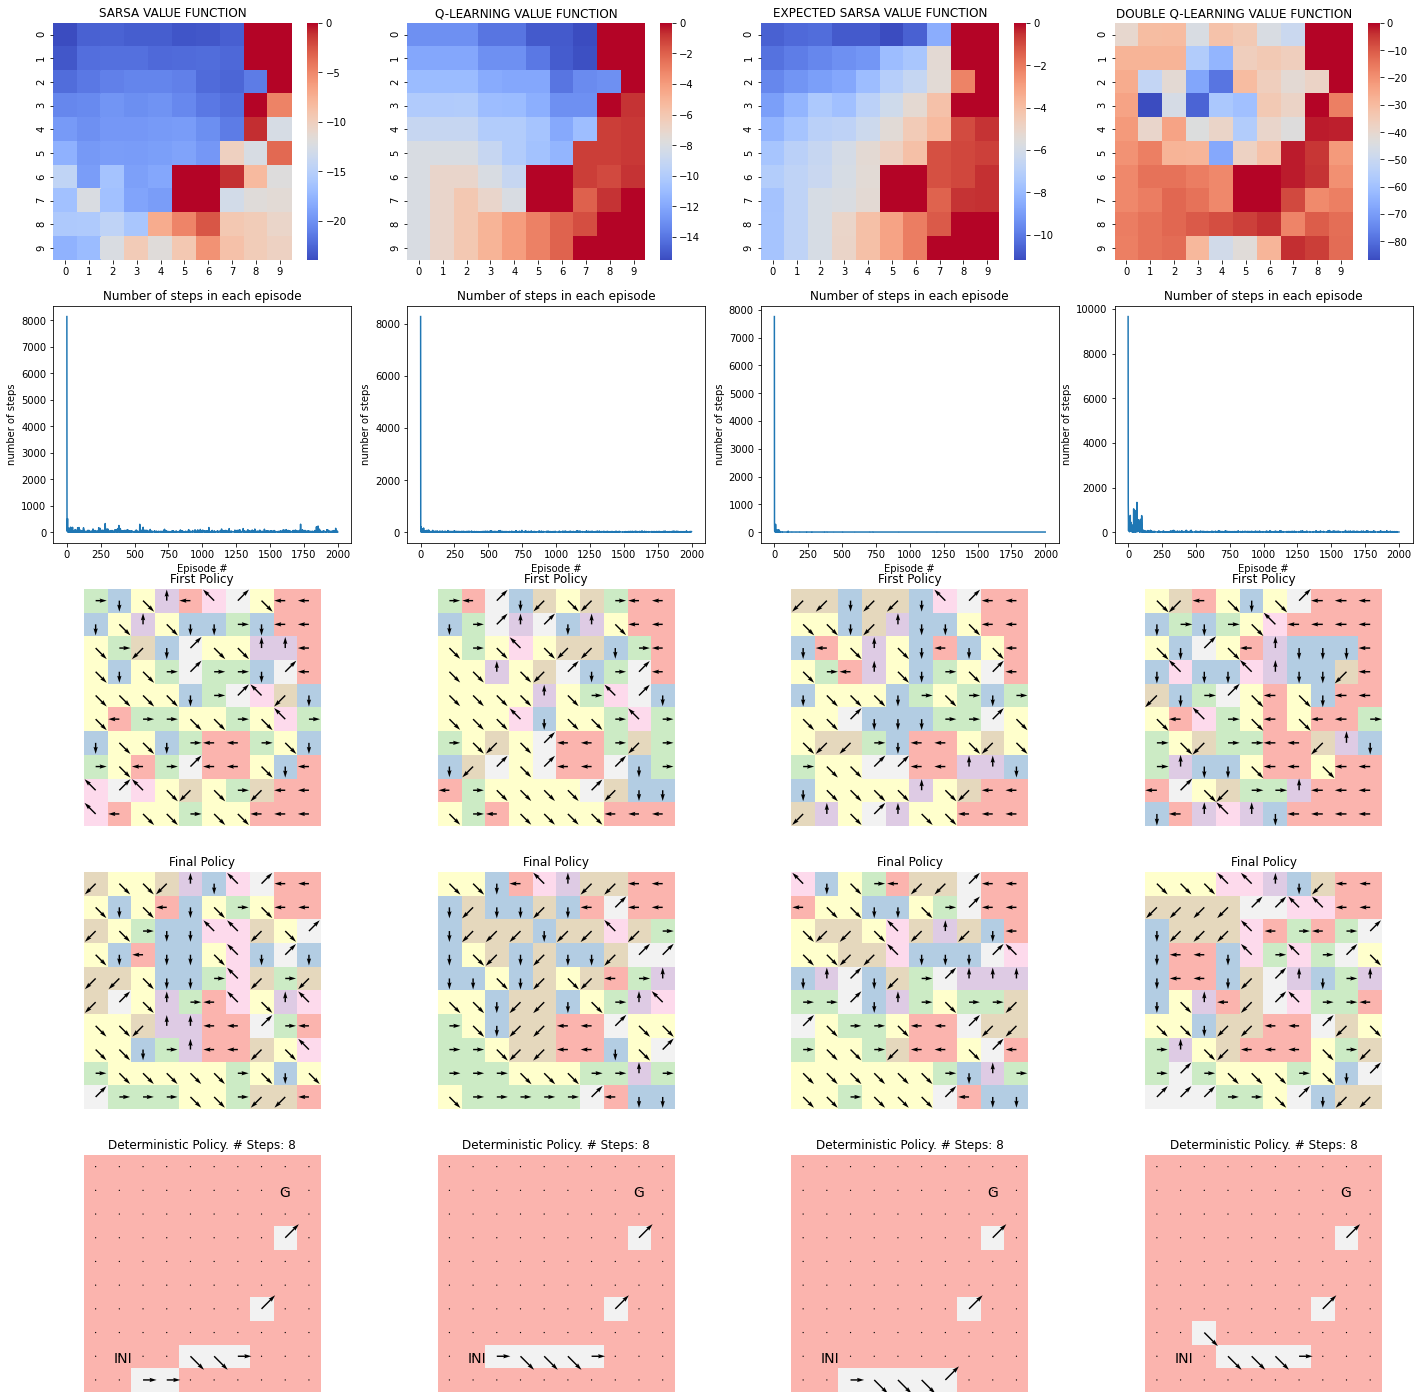

In [11]:
general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid)

Note that now the plots look a little bit messy but they make sense taking into account the changes we made.
For instance, the arrows now take diagonal moves and there are a lot of empty spaces (without arrow actions) because we have both vertical and horizontal wind.

Moreover, on the value function plots, we can detect the forbidden cell block we added. As we do not allow the agent to access these cells, it can not explore them (never!), hence its value cells are 0. For this reason, the deterministic policy we see is not the easy one directly diagonal to the final state, but surrounding the forbidden cells.

Finally, note that now the number of steps in each episode has noticeably decreased. That is due to the fact that now we allow diagonal moves, so the agent can approach the final steps in half the time (half the steps).

---

Additionally, we test one last feature on the game by also keeping all the already implemented ones (diagonal moves, horizontal and vertical wind) and we change the blocking cells by making them "cliff cells". That is, again the agent cannot access these cells, but now if we land on them we return to the initial state.

Now, for doing so, we must tell the agent that the action of jumping off the cliff it is not worth it nor efficient, so we punish these behaviour by a high negative reward, say -10.

In [12]:
class GridWorld():
    def __init__(self):
        self.N_ROWS = 10
        self.N_COLUMNS = 10
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        # Define parameters
        self.GAMMA = 1
        self.ALPHA = 0.5
        self.EPSILON = 0.1
        self.N_EPISODES = 2000

        # left/down/right/up action
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0), (1, 1), (1, -1), (-1, -1), (-1, 1)]

        self.N_ACTIONS = len(self.ACTIONS)
        
        # Define inital and final state
        self.INI_STATE = 18
        self.FIN_STATE = 81

        # Define wind for each row and column
        self.WIND_V = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
        self.WIND_H = [-1, -1, -2, -1, -1, 0, 0, 0, 0, 0]
        
        # Define forbidden cells
        self.CLIFF_CELLS = [56, 57, 66, 67]

        # Define action-value function
        self.Q_FUN = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define second action-value function for double q-learning
        self.Q_FUN2 = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define state-value function only for plotting purposes    
        self.V_FUN = np.zeros(self.N_STATES)


    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1]*self.N_COLUMNS + state[0]


    '''
    Computes next state and reward

    Params:
        - int: state in {0,..., N_STATES-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: reward
    '''
    def next_position(self, state, action):

        (x,y) = self.get_XY(state)
        # x is the row number and y is the column number
        (ax, ay) = self.ACTIONS[action]
        
        row = max(0, x + ax + self.WIND_V[y])
        row = min(self.N_ROWS-1, row)
        
        col = max(0, y + ay + self.WIND_H[x])
        col = min(self.N_COLUMNS-1, col)
        
        next_state = (row, col)

        next_state = self.get_state(next_state)
        reward = -1
        
        if next_state in self.CLIFF_CELLS:
            next_state = self.INI_STATE
            reward = -10

        if next_state == self.FIN_STATE:
            return next_state, 0
        return next_state, reward

    '''
    Performs greedy policy. With prob epsilon pick action
    belonging to maximum action-value. With prob 1-epsilon
    pick a random action.

    Params:
        - int: state in {0,..., N_STATES-1}
        - bool: double, indicates whether we are using double q-learning or not
    Returns:
        - int: action in {0,..., N_ACTIONS-1}
    '''
    def greedy_policy(self, state, double=False):

        action = np.argmax(self.Q_FUN[state])
        if double:
            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state])

        if random() < self.EPSILON:
            action = randint(0, self.N_ACTIONS - 1)
        
        return action

    '''
    Compute state-value function

    Returns:
        - list: V_FUN
    '''
    def compute_v_fun(self):
        for i, action_values in enumerate(self.Q_FUN):
            self.V_FUN[i] = np.max(self.Q_FUN[i] + self.Q_FUN2[i])  # QFUN2[i] will be != 0 only in Double Q-Learning
        return self.V_FUN

    '''
    Compute actions taken in each state.

    Params:
        - boolean: double, indicates whether we are using double q-learning or not
    Returns:
        - list: actions, one for each state
    '''
    def compute_actions(self, double=False):
        actions = []
        for s in range(self.N_STATES):
            if double:
                actions.append(np.argmax(self.Q_FUN[s] + self.Q_FUN2[s]))
            else:
                actions.append(np.argmax(self.Q_FUN[s]))

        return actions

    '''
    The following functions are the different algorithms we will try.
    Basically we do two things:
        1. Compute next_state and next_action
        2. Update action-values (Q_FUN)

    Params:
        - int: state in {0,..., N_STATES-1}
        - int: action in {0,..., N_ACTIONS-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: next_action in {0,..., N_ACTIONS-1}
    '''
    def sarsa(self, state, action):
        
        # sarsa uses greedy policy for next action too
        
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state,next_action] - self.Q_FUN[state,action])
        
        return next_state, next_action
    

    def q_learning(self, state, action):

        # q-learning always pick next_action with maximum action-value (q-value)
        
        action = self.greedy_policy(state)
        next_state, reward = self.next_position(state, action)
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*np.max(self.Q_FUN[next_state]) - self.Q_FUN[state,action])
        
        return next_state, action


    def expected_sarsa(self, state, action):
        
        # expected sarsa is like q-learning but weighting with epsilon and also taking into account
        # the rest of action-values of that state

        next_state, reward = self.next_position(state, action)
        next_action = np.argmax(self.Q_FUN[next_state])
        
        policy = self.EPSILON/self.N_ACTIONS * np.ones(self.N_ACTIONS)
        policy[next_action] = 1 - self.EPSILON - self.EPSILON/self.N_ACTIONS
        
        self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*np.dot(policy, self.Q_FUN[next_state]) - self.Q_FUN[state,action])
        
        return next_state, next_action
    
    
    def double_q_learning(self, state, action):
        # Choose action taking into account both Q_FUNs

        # With 50% we will update Q_FUN or Q_FUN2. In either case, the actual q-value taken when computing the td_target
        # is given by the other Q_FUN, but we use the function we are updating to choose the next_action.
        
        action = self.greedy_policy(state, double=True)
        next_state, reward = self.next_position(state, action)
        
        if random() < 0.5:
            next_action = np.argmax(self.Q_FUN[next_state])
            self.Q_FUN[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN2[next_state, next_action] - self.Q_FUN[state,action])
        else:
            next_action = np.argmax(self.Q_FUN2[next_state])
            self.Q_FUN2[state,action] += self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state, next_action] - self.Q_FUN2[state,action])
        
        return next_state, action
    

    def deterministic_policy(self):
        max_steps = 50
        state = self.INI_STATE
        trajectory = np.zeros((self.N_ROWS, self.N_COLUMNS))
        steps = 0
        while not state == self.FIN_STATE and steps < max_steps:
            

            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state]) # QFUN2[i] will be != 0 only in Double Q-Learning
            next_state, reward = self.next_position(state, action)
            state = next_state
            steps += 1

            s = self.get_XY(state)
            trajectory[s[0], s[1]] = 1

        trajectory[s[0], s[1]] = 0
        if steps == max_steps:
            steps = 'inf'
        return trajectory, steps


In [13]:

total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []

for ALGORITHM in range(1,5):
    grid = GridWorld()
    counts = []
    for i in range(grid.N_EPISODES):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        n_count = 0
        
        while not state == grid.FIN_STATE:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action)

            action = next_action
            state = next_state

            n_count += 1
        if i==0:
            first_policy = grid.compute_actions()
        counts.append(n_count)
    
    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)


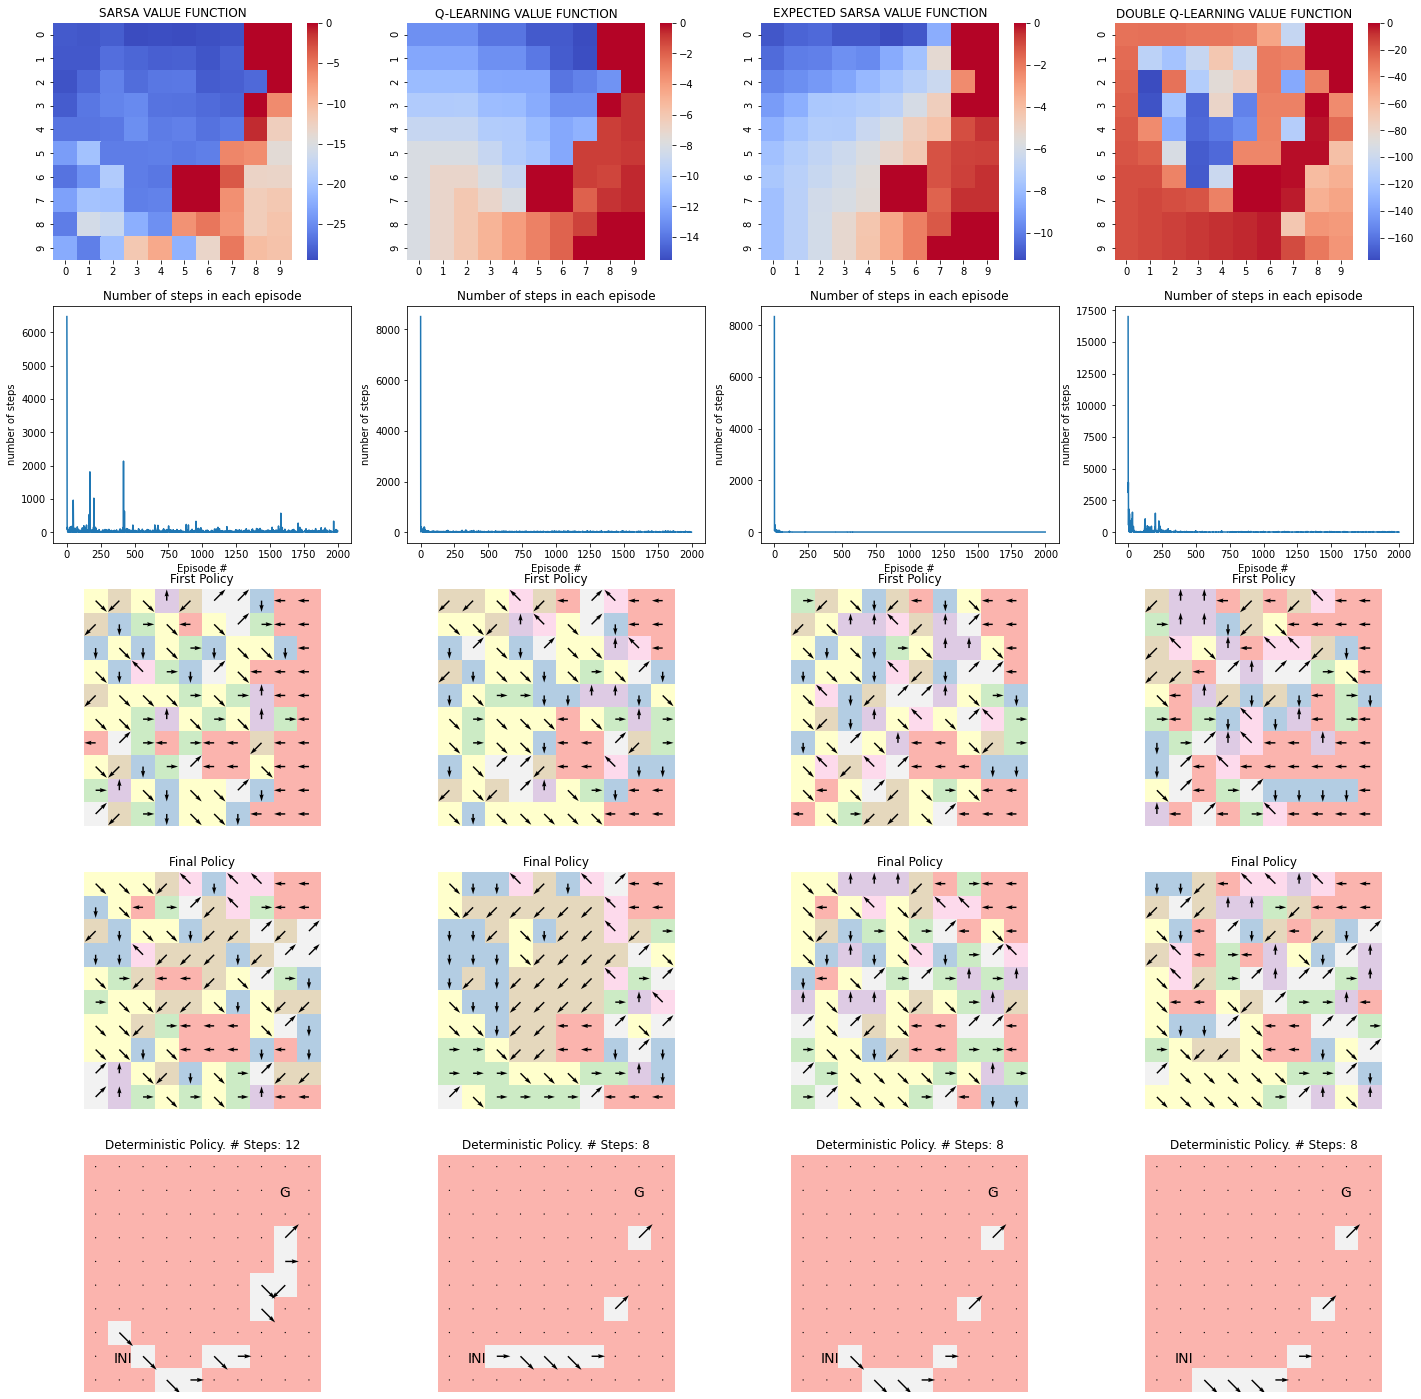

In [14]:
general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid)

As a final comment, we state that this other example works also well and the interpretations of the results are similar to those descrived above. We just highlight that SARSA and Expected SARSA seem to use a more prudent path, while the other two algorithms explore a bit more around the cliff. However, we are surprised by the results of both tests (given that we have introduced a "more difficult" problem somehow) and the relatively low number of steps the algorithms took.